In [0]:
# Import Packages and Corpus
import nltk
import random
import string
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
from IPython.display import SVG
from nltk.corpus import gutenberg, stopwords 

from keras.preprocessing import text
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import skipgrams
from keras.layers import Dot, Input
from keras.layers.core import Dense, Reshape
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.utils import plot_model, vis_utils
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE


nltk.download('punkt')
nltk.download('gutenberg')
nltk.download('stopwords')

stop_words = set(stopwords.words('english')) 

# Train Data - 3 documents form the Gusten corpus
austen = gutenberg.sents('austen-sense.txt') + gutenberg.sents('austen-emma.txt')
austen = austen + gutenberg.sents('austen-persuasion.txt') 
# Sanity Check
print(len(austen))

Using TensorFlow backend.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
16498


In [0]:
def preprocess(word_list):
  sequence = ' '.join(word for word in word_list)
  lower_words = text_to_word_sequence(sequence, filters=string.punctuation, lower=True, split=' ')
  Fsentences = [] 
  for word in lower_words:
    if word not in stop_words and not word.isdigit():
      Fsentences.append(word)
  return ' '.join(word for word in Fsentences)     

In [0]:
Ncorpus = []
for i in range(len(austen)):
  Csent = preprocess(austen[i])
  # Removing sentence which only contains less or equal to 2 words
  if len(Csent.split(' ')) > 2:
    Ncorpus.append(Csent)
    
# Sanity Check
print('Length of processed corpus:', len(Ncorpus))
print('Processed line:', Ncorpus[10])

Length of processed corpus: 13927
Processed line: therefore succession norland estate really important sisters fortune independent might arise father inheriting property could small


Create Corpus vocab and preapration of dataset

In [0]:
# Creating the Corpus Vocabulary and Preparing the Dataset
t = text.Tokenizer()
t.fit_on_texts(Ncorpus)
# zero for <PAD>
word2idx = t.word_index
idx2word = t.index_word
sents_as_ids = t.texts_to_sequences(Ncorpus)

vocab_size = len(word2idx.values()) + 1 
embed_size = 100

# Sanity Check
print('Number of unique words:', len(word2idx))
print('\nSample word2idx: ', random.choices(list(word2idx.items()), k=21))
print('\nSample idx2word:', list(idx2word.items())[:10])
print('\nSample normalized corpus:', Ncorpus[:3])
print('\nAbove sentence as a list of ids:' , sents_as_ids[:3])

Number of unique words: 10104

Sample word2idx:  [('captures', 9242), ('revolving', 6358), ('investigation', 5439), ('repent', 2591), ('relinquished', 5537), ('abominate', 10006), ('gravely', 2123), ('consulting', 3651), ('exquisitely', 10044), ('calculate', 4135), ('sup', 7663), ('implanted', 8468), ('floated', 8157), ('scissors', 3428), ('robin', 8357), ('elegantly', 4872), ('beheld', 3824), ('justification', 4599), ('relinquishment', 9238), ('patches', 7110), ('outrage', 8420)]

Sample idx2word: [(1, 'could'), (2, 'would'), (3, 'mr'), (4, 'mrs'), (5, 'must'), (6, 'said'), (7, 'one'), (8, 'much'), (9, 'miss'), (10, 'every')]

Sample normalized corpus: ['sense sensibility jane austen', 'family dashwood long settled sussex', 'estate large residence norland park centre property many generations lived respectable manner engage general good opinion surrounding acquaintance']

Above sentence as a list of ids: [[305, 1379, 75, 4297], [108, 101, 57, 333, 2588], [1022, 405, 1627, 597, 554, 27

In [0]:
# Generating training instances
skip_grams = [skipgrams(sent, vocabulary_size=vocab_size, window_size=5) for sent in sents_as_ids]

# Sanity Check
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(len(pairs)):
  print('({:s} ({:d}), {:s} ({:d})) -> {:d}'.format(
  # the first word and its index
  idx2word[pairs[i][0]], pairs[i][0],
  # the second word and its index
  idx2word[pairs[i][1]], pairs[i][1],
  # the label
  labels[i]))

(jane (75), sense (305)) -> 1
(sensibility (1379), austen (4297)) -> 1
(austen (4297), length (1412)) -> 0
(sensibility (1379), jane (75)) -> 1
(austen (4297), jane (75)) -> 1
(jane (75), bout (7238)) -> 0
(austen (4297), perplexity (2331)) -> 0
(sense (305), jane (75)) -> 1
(sense (305), began (218)) -> 0
(sense (305), motives (1900)) -> 0
(jane (75), sensibility (1379)) -> 1
(jane (75), inconveniently (7639)) -> 0
(sense (305), beg (1050)) -> 0
(sensibility (1379), concerning (3958)) -> 0
(austen (4297), sensibility (1379)) -> 1
(jane (75), imitate (7476)) -> 0
(austen (4297), informed (1171)) -> 0
(austen (4297), sense (305)) -> 1
(sensibility (1379), throughout (3241)) -> 0
(jane (75), austen (4297)) -> 1
(sensibility (1379), commonplace (4223)) -> 0
(sense (305), austen (4297)) -> 1
(sense (305), sensibility (1379)) -> 1
(sensibility (1379), sense (305)) -> 1


# Building neural network for skip-gram

In [0]:
target_word = Input((1,), dtype='int32')
target_embedding = Embedding(vocab_size, 
                             embed_size, 
                             name='target_embed_layer',
                             embeddings_initializer='glorot_uniform',
                             input_length=1)(target_word)
target_input = Reshape((embed_size, ))(target_embedding)
context_word = Input((1,), dtype='int32')
context_embedding = Embedding(vocab_size, embed_size, name='context_embed_layer',
                              embeddings_initializer='glorot_uniform',
                              input_length=1)(context_word)
context_input = Reshape((embed_size, ))(context_embedding)
merged_inputs = Dot(axes=-1, normalize=False)([target_input, context_input])
label = Dense(units=1, 
              kernel_initializer='glorot_uniform',
              activation='sigmoid')(merged_inputs)

model = Model(inputs=[target_word, context_word], outputs=[label])

model.compile(loss='mean_squared_error', optimizer='rmsprop')

# Sanity Check
model.summary()





Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
target_embed_layer (Embedding)  (None, 1, 100)       1010500     input_1[0][0]                    
__________________________________________________________________________________________________
context_embed_layer (Embedding) (None, 1, 100)       1010500     input_2[0][0]                    
________________________________________________________________________________________

In [0]:
# Train the model
for epoch in range(1, 6):
  epoch_loss = 0
  # in each epoch, train all the sentences, one per iteration=> batch_size = num_sents
  for i, sent_examples in enumerate(skip_grams):
    target_wds = np.array([pair[0] for pair in sent_examples[0]], dtype='int32')
    context_wds = np.array([pair[1] for pair in sent_examples[0]], dtype='int32')
    labels = np.array(sent_examples[1], dtype='int32')
    X = [target_wds, context_wds]
    Y = labels
    if i % 5000 == 0: # after 5000 sentences i.e. 5000 iterations
      print('Processed %d sentences' %i)
    epoch_loss += model.train_on_batch(X, Y)
  print('Processed all %d sentences' %i)
  print('Epoch:', epoch, 'Loss:', epoch_loss, '\n')

Processed 0 sentences








Processed 5000 sentences
Processed 10000 sentences
Processed all 13926 sentences
Epoch: 1 Loss: 2400.2854716442525 

Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed all 13926 sentences
Epoch: 2 Loss: 1961.2278094263747 

Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed all 13926 sentences
Epoch: 3 Loss: 1878.4176778041292 

Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed all 13926 sentences
Epoch: 4 Loss: 1834.2059173785383 

Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed all 13926 sentences
Epoch: 5 Loss: 1813.3783828822197 



In [0]:
# Get the word embedding
word_embeddings = model.get_layer('target_embed_layer').get_weights()[0][1:]

# Sanity Check
print(word_embeddings.shape)
print(DataFrame(word_embeddings, index=idx2word.values()).head(10))

(10104, 100)
             0         1         2   ...        97        98        99
could -0.000964 -0.029424  0.130153  ...  0.034465  0.139711 -0.182901
would -0.042396 -0.076731 -0.174543  ...  0.000954 -0.150704 -0.282044
mr    -0.084814  0.044369 -0.023342  ...  0.085666 -0.088126 -0.162431
mrs   -0.067577  0.061958  0.030435  ...  0.061493 -0.307603 -0.191542
must  -0.025393  0.109750  0.098294  ...  0.034803 -0.087551 -0.071194
said  -0.043349 -0.054695  0.079312  ...  0.040824  0.030287 -0.235119
one    0.028626 -0.049119  0.129968  ...  0.045919  0.103490 -0.158919
much   0.059237  0.271311  0.095030  ...  0.040019 -0.009000 -0.195685
miss   0.147794  0.218513 -0.111300  ... -0.078598  0.070679 -0.155426
every -0.114780 -0.010442  0.021867  ... -0.168410  0.134021  0.121020

[10 rows x 100 columns]


In [0]:
# Measuring Similarity Between Word Pairs
similarity_matrix = cosine_similarity(word_embeddings)

# Check
print(similarity_matrix.shape)

(10104, 10104)


In [0]:
# Exploring and Visualizing your Word Embeddings using t-SNE
search_items = ['man', 'love', 'hatred', 'woman', 'wisdom', 'kindness', 'god', 'man', 'folly', 'fool']
similar_words = {term: [idx2word[idx] for idx in (-1 * similarity_matrix[word2idx[term]-1]).argsort()[1:6] + 1]
                 for term in search_items}

# Sanity Check
print(similar_words)

{'man': ['satirical', 'existed', 'safest', 'connoisseur', 'son'], 'love': ['viewing', 'whirling', 'figuratively', 'carelessly', 'sonnet'], 'hatred': ['unite', 'modestly', 'slope', 'several', 'grudge'], 'woman': ['quieter', 'young', 'quarters', 'meet', 'elizabeth'], 'wisdom': ['innocence', 'stricken', 'unkind', 'repast', 'graces'], 'kindness': ['anne', 'sight', 'get', 'politeness', 'grandson'], 'god': ['toilsome', 'blocked', 'sarcastically', 'consequent', 'option'], 'folly': ['combine', 'shifts', 'west', 'unattended', 'fluctuating'], 'fool': ['killed', 'overhearing', 'hymen', 'contriving', 'folks']}


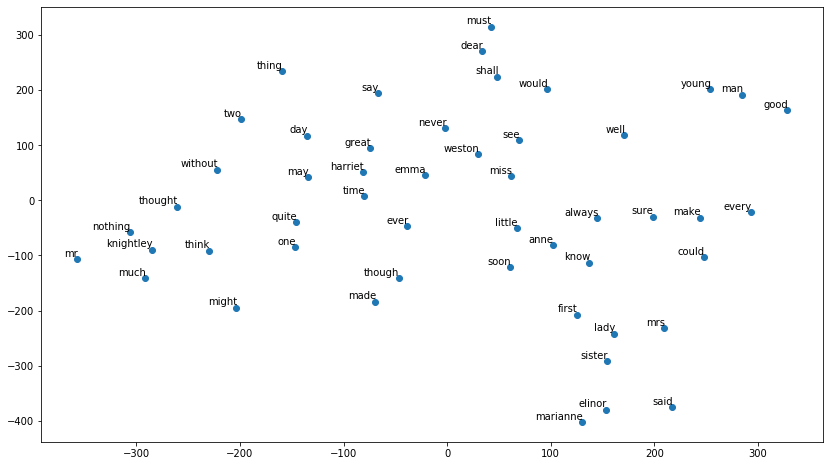

In [0]:
# Plot the words in the dictionary above using t-SNE 
tsne = TSNE(perplexity=3, n_components=2, init='pca', n_iter=5000, method='exact')
plot_only = 50
T = tsne.fit_transform(word_embeddings[:plot_only, :])
labels = [idx2word[i+1] for i in range(plot_only)]
plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1])
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), 
                 textcoords='offset points', ha='right',va='bottom')